# 2025 ASAP CRN Colloborative Meeting - CRN Cloud Training Workshop Notebook #4

## Overview
This notebook is Part 4: **Differential Expression (DE) Analysis**

## Outline 

4. [Differential Expression (DE) Analysis (__Take Home__)](#part-4-differential-expression-de-analysis-advanced)
    * Differential expression analysis,
        * psuedobulk over 'sample' and 'cell_type' 
        * logistic regression CASE vs. CONTROL
    * Differential expression analysis meta-analysis
        * psuedobulk over 'sample' and 'cell_type' 
        * logistic regression CASE vs. CONTROL per source dataset
        * statistical meta analysis to verify consistency across Datasets / Teams


## Notebooks
All of this content can be found in shorter more specific notebooks.  E.g. During the workshop you can follow along for Parts 1 & 2, but should start with Part 3 ([03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb))

- This notebook [00_full_example_notebook.ipynb](./00_full_example_notebook.ipynb)
    - Part 1 - [01_basic_EDA.ipynb](./01_basic_EDA.ipynb)  
    - Part 2 - [02_dataset_composition.ipynb](./02_dataset_composition.ipynb)
    - Part 3 - [03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb)
        - Part 3-R - [03-R_GOI_analysis.ipynb](./03-R_GOI_analysis.ipynb)
    - Part 4 - [04_DE_analysis.ipynb](./04_DE_analysis.ipynb)



------------------------------
>> NOTES
>>   need to develop an equivalent R version for part 1,2, and 4
    



------------------------------
>> NOTES
>>   need to test that this runs reasonably fast on a generic VM
>>   need to develop an equivalent R version

## Imports

In [11]:
import numpy as np
import pandas as pd
import logging
import warnings

# Use pathlib for file path manipulation
from pathlib import Path 


# matplotlib and seaborn a pythonic alternative to plotnine
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except ImportError as e:
    print("Error -> ", e)
    print("Installing seaborn or matplotlib")
    !pip install matplotlib seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt


try:
    import scanpy as sc
except ImportError as e:
    print("Error -> ", e)
    print("Installing scanpy")
    !pip install scanpy
    import scanpy as sc


try:
    from scipy.stats import norm
    import statsmodels.formula.api as smf    
    from statsmodels.stats.multitest import multipletests

except ImportError as e:
    print("Error -> ", e)
    print("Installing scipy and statsmodel")
    !pip install scanpy statsmodel
    from scipy.stats import norm
    import statsmodels.formula.api as smf    
    from statsmodels.stats.multitest import multipletests

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

# Always show all columns in a Pandas DataFrame
pd.set_option('display.max_columns', None)

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.58 ms (started: 2025-02-27 09:36:06 +00:00)


###  ASAP CRN data paths
First, let's build the paths to our data. 

In [ ]:
# Workspace Path
HOME_PATH = Path.home()
WS_PATH =  HOME_PATH / 'workspace'
if not WS_PATH.exists():
    print(f"{WS_PATH} doesn't exist. We need to remount our resources")
    !wb resource mount    

time: 1.26 ms (started: 2025-02-27 09:36:07 +00:00)


We'll focus in on the datasets processed with our *PMDBS scRNAseq* workflow.  Specifically the _cohort_ dataset: `asap-cohort-pmdbs-sc-rnaseq`.  This dataset includes samples from 5 Contributing datasets which have been processesed and integrated.  The paths include the following parts.

- `workflow` designates the workflow which performs the aggregation and integration.  In this case the [*PMDBS scRNAseq* workflow](https://github.com/ASAP-CRN/pmdbs-sc-rnaseq-wf)
- `dataset_team` designates the contributing team for the dataset.  In this case _cohort_ designates that it is made from multiple individual contributed datasets.
- `source` designates the _source_ of the samples.  In this case Post-mortem derived Brain samples
- `dataset_type` designates the 
- `bucket_name` designates the datasets gcp bucket
- `dataset_name` designates the unique designation for each dataset or collection

In [13]:
DATASETS_PATH = WS_PATH / "01_PMDBS_scRNAseq_Datasets"
workflow = "pmdbs_sc_rnaseq"
dataset_team = "cohort"
dataset_source = "pmdbs"
dataset_type = "sc-rnaseq"
bucket_name = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_path = DATASETS_PATH / bucket_name / workflow

time: 910 μs (started: 2025-02-27 09:36:12 +00:00)


#### Cohort Analysis Path

Now that we've defined the path to our cohort dataset, lets list the curated files for the `cohort_analysis`.   

In [14]:
cohort_analysis_path = dataset_path / "cohort_analysis"

time: 468 μs (started: 2025-02-27 09:36:12 +00:00)


#### Dataset Metadata Path

The dataset metadata can be found in the `release_resources`.  Note that the metadata are organized by the _short_ `dataset_name` rather than `bucket_name`.  



In [ ]:
ds_metadata_path = WS_PATH / 'release_resources/asap-crn-cloud-release-resources' / dataset_name / "metadata"

!ls {ds_metadata_path} 

time: 428 μs (started: 2025-02-27 09:36:26 +00:00)


#### Workshop/Notebook Artifact Path

This is the path to where the artifacts we've created in these notebooks can be found in case you want to skip ahead.  Particularly for the workshop.

In [ ]:
WORKSHOP_PATH = WS_PATH / "release_resources/asap-crn-cloud-release-resources/release-artifacts/2025_CRN_CM_Workshop_Resources_03122025" 

!ls {WORKSHOP_PATH}


time: 532 μs (started: 2025-02-27 09:36:16 +00:00)


#### Local Data Path
Lets also define a path for copying our data files and exporting intermediate analysis artifacts to your workspace.  In this example we'll make a "workshop_files" in the "ws_files" which are persistent in our Verily Workbench Workspace. 

In [ ]:
local_data_path = WS_PATH / "workshop_files"

if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

time: 373 ms (started: 2025-02-27 09:36:15 +00:00)


----------------------
# Part 4: Differential Expression (DE) Analysis (__Advanced__)
* Differential expression analysis
* Differential expression analysis meta-analysis

Here we'll run through a simple differential analysis of gene expression aimed at finding which genes are over/under-expressed in Frontal Cortex derived PMDBS for Parkinson's patient brains versus Controls. 

We'll do psuedo-bulking by simply summing all cells derived from the same _sample_ having the same "cell_type".   

Caveat:  Cell-typing.   Our gene-expression phenotype ("cell_type") have been inferred for a simple taxonomy leveraging by a very naive set of marker genes with `CellAssign`.   A more powerful procedure for infering ground-truth gene-expression phenotype, would enhance the utility of this analysis.


### Load full frontal cortex `AnnData` object for further analysis 

If you calculated these yourself in [Part 2 - 02_dataset_composition.ipynb](./02_dataset_composition.ipynb) load if from where you saved it.(e.g. 'local_data_path'). If you didn't do that, and you didn't already copy it to your 'local_data_path', it is also made it available in the `WORKSHOP_PATH`.

In [ ]:
full_frontal_samples_filename = local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"

frontal_full_ad = sc.read_h5ad(full_frontal_samples_filename)

time: 12 s (started: 2025-02-27 09:37:16 +00:00)


In [20]:
adata = frontal_full_ad
adata

AnnData object with n_obs × n_vars = 291787 × 36601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'cell_type', 'case_control', 'condition_id', 'case_id', 'brain_region'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden', 'log1p', 'neighbors', 'pca', 'phase_colors', 'scrublet', 'target_false_positive_rate', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_scvi', 'X_umap', '_scvi_extra_continuous_covs', 'gene_expression_

time: 22.4 ms (started: 2025-02-27 09:37:43 +00:00)


full_frontal_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"
)
adata = sc.read_h5ad(full_frontal_samples_filename)


## Construct Simple Psuedobulk

We'll create a _simple_ psuedobulk dataset by summing counts over cells from individual samples for each cell_type. 

> Note: it might be more elegant to use the `decoupler` framework to construct psuedobulk gene-expression, but the goal here was simply to demonstrate the logic. 

In [ ]:
# create pseudo-bulk expression matrix
gene_ids = adata.var["gene_id"]
pbs = []
for cell_type in adata.obs["cell_type"].unique():
    cell_type_adata = adata[adata.obs["cell_type"] == cell_type]

    for sample in cell_type_adata.obs["sample"].unique():
        samp_cell_subset = cell_type_adata[cell_type_adata.obs["sample"] == sample]
        X = samp_cell_subset.X.toarray()
        rep_adata = sc.AnnData(
            X=X.sum(axis=0).reshape(1, -1),
            var=samp_cell_subset.var[[]],
        )
        rep_adata.obs_names = [cell_type + "_" + sample]
        rep_adata.obs["dataset"] = samp_cell_subset.obs["dataset"].iloc[0]
        rep_adata.obs["cell_type"] = samp_cell_subset.obs["cell_type"].iloc[0]
        rep_adata.obs["case_control"] = samp_cell_subset.obs["case_control"].iloc[0]

        pbs.append(rep_adata)


pb = sc.concat(pbs)

pb.var["gene_name"] = pb.var.index
pb.var_names = gene_ids
pb

AnnData object with n_obs × n_vars = 399 × 36601
    obs: 'dataset', 'cell_type', 'case_control'
    var: 'gene_name'

time: 35.1 s (started: 2025-02-25 23:05:33 +00:00)


In [ ]:
psuedobulk_cortical_samples_filename = local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk.h5ad"
pb.write_h5ad(psuedobulk_cortical_samples_filename)

time: 2.2 s (started: 2025-02-25 23:06:08 +00:00)


## Differential Expression

We will perform a super simple differential expression calculation by logistic regression for the log zscored samples for each gene on Case vs. Control.  

If you want to start from here simply load the psuedobulk anndata created above.

In [ ]:
reload = False

if reload:
    psuedobulk_cortical_samples_filename = (
        local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk.h5ad"
    )


    pb = sc.read_h5ad(psuedobulk_cortical_samples_filename)

### calculate differential expression

We'll take the log of the psuedobulks and zscore with `scanpy` to normalize the expression for each gene psuedobulk.  In this initial analysis we'll zscore and regress all the cells per `cell_type`.
This takes about 20 minutes.

In [48]:
#use logger and ignore warnings so this doesn't swamp the notebook with output

logger = logging.getLogger()
fhandler = logging.FileHandler(filename="nb_log.log", mode="w")
logger.addHandler(fhandler)
logging.warning("This is a warning message")


warnings.filterwarnings("ignore")

# Initialize a DataFrame to store results for this subdirectory
# Step 3: Loop over cell types and perform logistic regression
regression_count = 0
results = pd.DataFrame(columns=["CELL_TYPE", "ENSG", "BETA", "SE", "P", "N"])

for cell_type in pb.obs["cell_type"].unique():
    cell_type_pb = pb[pb.obs["cell_type"] == cell_type].copy()
    logging.info(f" {cell_type=}, {cell_type_pb.shape=}")

    # Step 4: Apply log-transform and z-scaling for each cell_type
    sc.pp.log1p(cell_type_pb)
    sc.pp.scale(cell_type_pb)

    # X = cell_type_pb.X.toarray()
    # log_transformed = np.log1p(X)
    # z_scaled = (log_transformed - log_transformed.mean()) / log_transformed.std(ddof=0)

    # Step 5: Perform logistic regression for each gene
    # Iterate over ENSG prefixed columns
    for ensg in cell_type_pb.var_names:
        regression_count += 1
        try:
            data = cell_type_pb.obs[["case_control"]]
            data = (cell_type_pb.obs[["case_control"]] != "Control").astype(int)
            data[ensg] = cell_type_pb[:, ensg].X.toarray()
            # Perform logistic regression
            formula = f"case_control ~ {ensg}"
            model = smf.logit(formula, data=data).fit(disp=False)

            # Extract results
            beta = model.params[ensg]
            se = model.bse[ensg]
            p_value = model.pvalues[ensg]
            n = model.nobs

            # Create a new row of results
            new_row = pd.DataFrame(
                [
                    {
                        "CELL_TYPE": cell_type,
                        "ENSG": ensg,
                        "BETA": beta,
                        "SE": se,
                        "P": p_value,
                        "N": n,
                    }
                ]
            )
            # Append to results table
            results = pd.concat([results, new_row], ignore_index=True)

            # Print only every 1000th model
            if regression_count % 1000 == 0:
                msg = f"\nRegression {regression_count} in {cell_type}:"
                msg += f"\nFormula: {formula}"
                msg += f"\n{model.summary()}"
                logging.info(msg)

        except Exception as e:
            # print(f"Error analyzing  {cell_type}, {ensg}: {e}")
            logging.error(f"Error analyzing  {cell_type}, {ensg}: {e}")


simple_de_filenm = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.csv"
)

results.to_csv(simple_de_filenm, index=False)

time: 52min 3s (started: 2025-02-25 23:18:26 +00:00)


### Visualize DE Results

Below is a function to make a simple volcano plot.

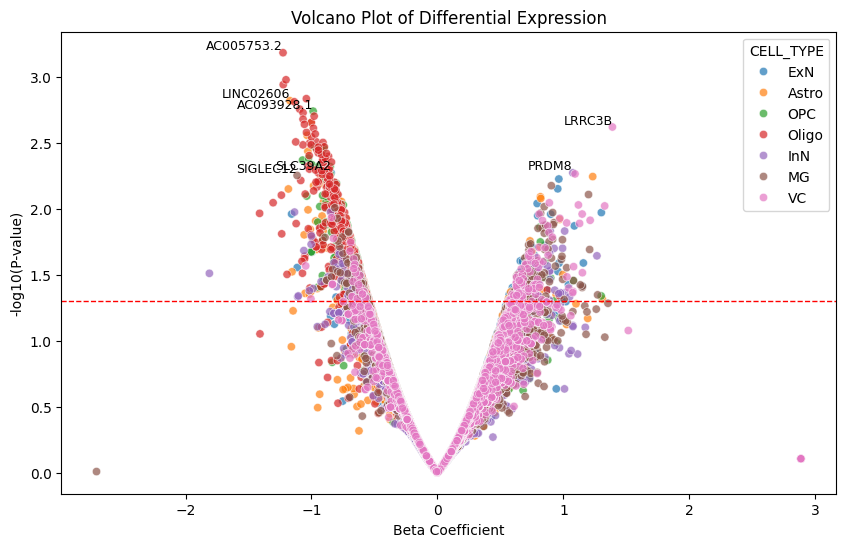

,CELL_TYPE,ENSG,BETA,SE,P,N,minus_log10_p,gene_name
35406,Astro,ENSG00000284693,-1.170897,0.369378,0.001525,59,2.816779,LINC02606
23049,ExN,ENSG00000165794,-0.844171,0.303143,0.005357,59,2.271058,SLC39A2
140534,InN,ENSG00000152784,1.074436,0.385836,0.005358,47,2.271013,PRDM8
186889,MG,ENSG00000254521,-1.114150,0.402272,0.005612,59,2.250895,SIGLEC12
73994,OPC,ENSG00000286952,-0.986917,0.316656,0.001829,59,2.737799,AC093928.1
110959,Oligo,ENSG00000286736,-1.225868,0.359963,0.000660,59,3.180237,AC005753.2
194547,VC,ENSG00000179796,1.388837,0.457715,0.002411,57,2.617786,LRRC3B


time: 5.56 s (started: 2025-02-26 00:10:30 +00:00)


In [49]:
def simple_volcano(results: pd.DataFrame, ensg_to_gene: pd.DataFrame):
    # Create a new column for -log10(p)
    results["minus_log10_p"] = -np.log10(results["P"])
    df = results.copy()
    # Ignore rows where BETA > |3|
    df = df[df["BETA"].abs() <= 3]

    df = df.merge(ensg_to_gene, left_on="ENSG", right_index=True, how="left")

    # For each cell type, find the gene with the highest -log10 p-value
    top_hits = df.loc[df.groupby("CELL_TYPE")["minus_log10_p"].idxmax()]

    plt.figure(figsize=(10, 6))
    # Use seaborn to plot with CELL_TYPE as hue and N to adjust marker sizes
    sns.scatterplot(data=df, x="BETA", y="minus_log10_p", hue="CELL_TYPE", alpha=0.7)

    # Annotate the top 10 genes on the plot
    for _, row in top_hits.iterrows():
        # You can adjust the text offset (e.g., using ha, va, or adding a small offset to x/y)
        plt.text(
            row["BETA"],
            row["minus_log10_p"],
            row["gene_name"],
            fontsize=9,
            ha="right",
            va="bottom",
        )

    # Add a horizontal line for p=0.05 (optional threshold)
    plt.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1)

    plt.xlabel("Beta Coefficient")
    plt.ylabel("-log10(P-value)")
    plt.title("Volcano Plot of Differential Expression")
    plt.show()
    return top_hits


top_hits_by_cell_type = simple_volcano(results, pb.var.copy())
top_hits_by_cell_type

## DE meta analysis 

This meta analysis tests the robustness of the DE across individual contributions in our 'asap-cohort' dataset.


### calculate differential expression

In the previous section we calculated the Case/Control DE for each cell_type with logistic regression on the log zscores of our psuedobulks.   Now we need to recalculate the DE for each cell_type for each dataset. 

In [50]:
results_by_dataset = {}

for dataset in pb.obs["dataset"].unique():
    dataset_adata = pb[pb.obs["dataset"] == dataset]
    results = pd.DataFrame(
        columns=["DATASET", "CELL_TYPE", "ENSG", "BETA", "SE", "P", "N"]
    )

    regression_count = 0
    for cell_type in dataset_adata.obs["cell_type"].unique():
        cell_type_pb = dataset_adata[dataset_adata.obs["cell_type"] == cell_type].copy()
        print(cell_type, cell_type_pb.shape)

        # Step 4: Apply log-transform and z-scaling for each cell_type
        sc.pp.log1p(cell_type_pb)
        sc.pp.scale(cell_type_pb)

        # X = cell_type_pb.X.toarray()
        # log_transformed = np.log1p(X)
        # z_scaled = (log_transformed - log_transformed.mean()) / log_transformed.std(ddof=0)

        # Step 5: Perform logistic regression for each gene
        # Iterate over ENSG prefixed columns
        for ensg in cell_type_pb.var_names:
            regression_count += 1
            try:

                data = cell_type_pb.obs[["case_control"]]
                data = (cell_type_pb.obs[["case_control"]] != "Control").astype(int)
                data[ensg] = cell_type_pb[:, ensg].X.toarray()
                # Perform logistic regression
                formula = f"case_control ~ {ensg}"
                model = smf.logit(formula, data=data).fit(disp=False)

                # Extract results
                beta = model.params[ensg]
                se = model.bse[ensg]
                p_value = model.pvalues[ensg]
                n = model.nobs

                # Create a new row of results
                new_row = pd.DataFrame(
                    [
                        {
                            "DATASET": dataset,
                            "CELL_TYPE": cell_type,
                            "ENSG": ensg,
                            "BETA": beta,
                            "SE": se,
                            "P": p_value,
                            "N": n,
                        }
                    ]
                )
                # Append to results table
                results = pd.concat([results, new_row], ignore_index=True)

                # Print only every 1000th model
                if regression_count % 1000 == 0:
                    msg = f"\nRegression {regression_count} in {cell_type}:"
                    msg += f"\nFormula: {formula}"
                    msg += f"\n{model.summary()}"
                    logging.info(msg)

            except Exception as e:
                # print(f"Error analyzing  {cell_type}, {ensg}: {e}")
                logging.error(f"Error analyzing  {cell_type}, {ensg}: {e}")

    results_by_dataset[dataset] = results

    # Step 4: Export results for this subdirectory with a timestamp
    dataset_de_filenm = (
        local_data_path
        / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.meta_analysis_{dataset}.csv"
    )

    results.to_csv(dataset_de_filenm, index=False)

ExN (22, 36601)
Astro (22, 36601)
OPC (22, 36601)
Oligo (22, 36601)
InN (12, 36601)
MG (22, 36601)
VC (20, 36601)
ExN (12, 36601)
Astro (12, 36601)
OPC (12, 36601)
Oligo (12, 36601)
InN (12, 36601)
MG (12, 36601)
VC (12, 36601)
ExN (25, 36601)
Astro (25, 36601)
OPC (25, 36601)
Oligo (25, 36601)
InN (23, 36601)
MG (25, 36601)
VC (25, 36601)
time: 2h 39min 27s (started: 2025-02-26 00:10:35 +00:00)


In [51]:
all_data_df = pd.concat(results_by_dataset, ignore_index=True)

time: 48.9 ms (started: 2025-02-26 02:50:03 +00:00)


In [63]:
all_data_df

,DATASET,CELL_TYPE,ENSG,BETA,SE,P,N,FILE
0,DS_PMDBS_0004,ExN,ENSG00000243485,-0.182149,0.438393,0.677781,22,asap-cohort.full_frontal_ctx_psuedobulk_de.met...
1,DS_PMDBS_0004,ExN,ENSG00000238009,-0.042635,0.457299,0.925719,22,asap-cohort.full_frontal_ctx_psuedobulk_de.met...
2,DS_PMDBS_0004,ExN,ENSG00000239945,-0.291216,0.457279,0.524226,22,asap-cohort.full_frontal_ctx_psuedobulk_de.met...
4,DS_PMDBS_0004,ExN,ENSG00000241860,-0.219766,0.486330,0.651350,22,asap-cohort.full_frontal_ctx_psuedobulk_de.met...
6,DS_PMDBS_0004,ExN,ENSG00000286448,-0.086074,0.448005,0.847642,22,asap-cohort.full_frontal_ctx_psuedobulk_de.met...
...,...,...,...,...,...,...,...,...
584754,DS_PMDBS_0001,VC,ENSG00000273748,-0.184510,0.423723,0.663237,25,asap-cohort.full_frontal_ctx_psuedobulk_de.met...
584755,DS_PMDBS_0001,VC,ENSG00000271254,-0.000147,0.416669,0.999719,25,asap-cohort.full_frontal_ctx_psuedobulk_de.met...
584756,DS_PMDBS_0001,VC,ENSG00000276345,0.189131,0.433244,0.662441,25,asap-cohort.full_frontal_ctx_psuedobulk_de.met...
584757,DS_PMDBS_0001,VC,ENSG00000278817,0.092238,0.421541,0.826796,25,asap-cohort.full_frontal_ctx_psuedobulk_de.met...


time: 11.7 ms (started: 2025-02-26 03:44:33 +00:00)


###  Fixed effect and random-effect meta-analysis

These are the functions below that power the meta-analyses.


In [64]:
# Function to calculate fixed effect meta-analysis
def fixed_effect_meta_analysis(betas, ses):
    weights = 1 / (ses**2)
    beta_fe = np.sum(weights * betas) / np.sum(weights)
    se_fe = np.sqrt(1 / np.sum(weights))
    z_fe = beta_fe / se_fe
    p_fe = 2 * norm.sf(abs(z_fe))
    return beta_fe, se_fe, p_fe


# Function to calculate random effect meta-analysis
def random_effect_meta_analysis(betas, ses):
    weights = 1 / (ses**2)
    beta_fe, se_fe, _ = fixed_effect_meta_analysis(betas, ses)
    q_stat = np.sum(weights * ((betas - beta_fe) ** 2))
    df = len(betas) - 1
    tau2 = max(
        0, (q_stat - df) / (np.sum(weights) - np.sum(weights**2) / np.sum(weights))
    )
    weights_re = 1 / (ses**2 + tau2)
    beta_re = np.sum(weights_re * betas) / np.sum(weights_re)
    se_re = np.sqrt(1 / np.sum(weights_re))
    z_re = beta_re / se_re
    p_re = 2 * norm.sf(abs(z_re))
    i2 = max(0, ((q_stat - df) / q_stat) * 100 if q_stat > df else 0)
    return beta_re, se_re, p_re, i2

time: 1.47 ms (started: 2025-02-26 03:44:36 +00:00)


Note the code below deletes results whihc have a BETA value > |3|. A BETA value this large is indicative of poor model fit.
Also note, this is a strict FDR, correcting for all tests done across cell types.

In [65]:
dataset_de_filenms = local_data_path.glob(
    f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.meta_analysis_*.csv"
)
for file in dataset_de_filenms:
    print(file)

/home/jupyter/workspace/ws_files/workshop_files/asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0001.csv
/home/jupyter/workspace/ws_files/workshop_files/asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0002.csv
/home/jupyter/workspace/ws_files/workshop_files/asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0004.csv
time: 78.7 ms (started: 2025-02-26 03:44:37 +00:00)


In [66]:
data_loaded = True

if not data_loaded:
    #  Pull the trigger and meta-analyze
    all_data = []
    dataset_de_filenms = local_data_path.glob(
        f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.meta_analysis_*.csv"
    )
    for file in dataset_de_filenms:
        df = pd.read_csv(file)
        # Ignore rows where BETA > |3|
        df = df[df["BETA"].abs() <= 3]
        df["FILE"] = file.name
        all_data.append(df)

    # Combine all data
    all_data_df = pd.concat(all_data, ignore_index=True)

else:
    print("Data already loaded")
    # add a FILE column to the dataframe
    all_data_df["FILE"] = all_data_df["DATASET"].apply(
        lambda x: f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.meta_analysis_{x}.csv"
    )
    # Ignore rows where BETA > |3|
    all_data_df = all_data_df[all_data_df["BETA"].abs() <= 3]

Data already loaded
time: 401 ms (started: 2025-02-26 03:44:37 +00:00)


In [67]:
cell_type

'VC'

time: 2.7 ms (started: 2025-02-26 03:44:38 +00:00)


In [68]:
# Group by CELL_TYPE and ENSG
meta_analysis_results = []
for (cell_type, ensg), group in all_data_df.groupby(["CELL_TYPE", "ENSG"]):
    if group["FILE"].nunique() < 2:
        continue  # Skip combinations not present in at least two results files

    betas = group["BETA"].values
    ses = group["SE"].values

    # Perform fixed effect meta-analysis
    beta_fe, se_fe, p_fe = fixed_effect_meta_analysis(betas, ses)

    # Perform random effect meta-analysis
    beta_re, se_re, p_re, i2 = random_effect_meta_analysis(betas, ses)

    # Collect results
    meta_analysis_results.append(
        {
            "CELL_TYPE": cell_type,
            "ENSG": ensg,
            "BETA_FE": beta_fe,
            "SE_FE": se_fe,
            "P_FE": p_fe,
            "BETA_RE": beta_re,
            "SE_RE": se_re,
            "P_RE": p_re,
            "I2": i2,
        }
    )

# Convert results to DataFrame
results_df = pd.DataFrame(meta_analysis_results)

time: 1min 56s (started: 2025-02-26 03:44:38 +00:00)


In [69]:
# Apply FDR correction
results_df["P_FE_FDR"] = multipletests(results_df["P_FE"], method="fdr_bh")[1]
results_df["P_RE_FDR"] = multipletests(results_df["P_RE"], method="fdr_bh")[1]

# Save results to CSV
# timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
timestamp = pd.Timestamp.now().strftime("%Y%m%d")


output_file = local_data_path / f"meta_analysis_results_{timestamp}.csv"
results_df.to_csv(output_file, index=False)

print(f"Meta-analysis results saved to {output_file}")

Meta-analysis results saved to /home/jupyter/workspace/ws_files/workshop_files/meta_analysis_results_20250226.csv
time: 3.11 s (started: 2025-02-26 03:46:35 +00:00)


In [70]:
results_df["CELL_TYPE"].unique()

array(['Astro', 'ExN', 'InN', 'MG', 'OPC', 'Oligo', 'VC'], dtype=object)

time: 9.51 ms (started: 2025-02-26 03:46:38 +00:00)


### Summarize results

Lets see which genes are significant.   We'll also add gene-names for easy interrogation.

In [71]:
# Filter the rows where either P_FE_FDR or P_RE_FDR is significant (less than 0.05)
significant_rows = results_df[
    (results_df["P_FE_FDR"] < 0.05) | (results_df["P_RE_FDR"] < 0.05)
]
# Print the significant rows to the screen
print(significant_rows)

Empty DataFrame
Columns: [CELL_TYPE, ENSG, BETA_FE, SE_FE, P_FE, BETA_RE, SE_RE, P_RE, I2, P_FE_FDR, P_RE_FDR]
Index: []
time: 3.85 ms (started: 2025-02-26 03:46:38 +00:00)


In [72]:
significant_rows = significant_rows.merge(
    pb.var, left_on="ENSG", right_index=True, how="left"
)
significant_rows

,CELL_TYPE,ENSG,BETA_FE,SE_FE,P_FE,BETA_RE,SE_RE,P_RE,I2,P_FE_FDR,P_RE_FDR,gene_name


time: 17.4 ms (started: 2025-02-26 03:46:38 +00:00)


In [73]:
significant_rows["gene_name"]

Series([], Name: gene_name, dtype: object)

time: 3.12 ms (started: 2025-02-26 03:46:38 +00:00)


Nothing was consistent across the contributions with this analysis!  Null result.

-----------------
# Finished!!!

Well done!  Now you are ready to to leverage the ASAP CRN Cloud datasets!



In [ ]:
# ## Quick annotate the gene symbiols for easy use by others.
# ! pip install mygene

# import mygene

# # Initialize mygene
# mg = mygene.MyGeneInfo()

# ensg_ids = significant_rows["ensmbl_ID"].tolist()
# annotations = mg.querymany(
#     ensg_ids, scopes="ensembl.gene", fields="symbol", species="human"
# )

# # Create a mapping of ENSG IDs to gene symbols
# annotation_dict = {entry["query"]: entry.get("symbol", None) for entry in annotations}

# # Add a new column with gene symbols to the DataFrame
# significant_rows["Gene_Symbol"] = significant_rows["ensmbl_ID"].map(annotation_dict)

# significant_rows

--------------------
# Provenance
Generate information about this notebook environment and the packages installed.

In [24]:
!date

Thu Feb 27 10:12:33 AM UTC 2025
time: 130 ms (started: 2025-02-27 10:12:33 +00:00)


pip installed packages:

In [23]:
!pip freeze

absl-py==2.1.0
anndata==0.11.3
annotated-types==0.7.0
anyio==4.8.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_api_compat==1.10.0
arrow==1.3.0
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.4
attrs==25.1.0
awscli==1.22.34
babel==2.16.0
beautifulsoup4==4.12.3
bleach==6.2.0
blinker==1.4
botocore==1.23.34
cachetools==5.5.1
certifi==2020.6.20
cffi==1.17.1
chardet==4.0.0
charset-normalizer==3.4.1
colorama==0.4.4
comm==0.2.2
contourpy==1.3.1
cryptography==3.4.8
cycler==0.12.1
Cython==3.0.11
dbus-python==1.2.18
debugpy==1.8.12
decorator==5.1.1
defusedxml==0.7.1
distro==1.7.0
docstring_parser==0.16
docutils==0.17.1
exceptiongroup==1.2.2
executing==2.2.0
fastjsonschema==2.21.1
filelock==3.17.0
flatbuffers==25.1.24
fonttools==4.55.8
fqdn==1.5.1
gast==0.6.0
gitdb==4.0.12
GitPython==3.1.44
google-api-core==2.24.1
google-auth==2.38.0
google-auth-oauthlib==1.0.0
google-cloud-aiplatform==1.72.0
google-cloud-artifact-registry==1.13.1
google-cloud-bigquery==3.25.0
google-cloud-bigquery-co

JupyterLab extensions:

In [25]:
!jupyter labextension list

`sys_prefix` level settings are read-only, using `user` level for migration to `lockedExtensions`
JupyterLab v4.3.4
/home/jupyter/.local/share/jupyter/labextensions
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)
        jupyterlab-jupytext v1.4.3 enabled OK (python, jupytext)
        nbdime-jupyterlab v3.0.2 enabled OK
        @jupyterlab/git v0.50.2 enabled OK (python, jupyterlab-git)
        @jupyter-widgets/jupyterlab-manager v5.0.13 enabled OK (python, jupyterlab_widgets)

time: 2.19 s (started: 2025-02-27 10:12:38 +00:00)


Number of cores:

In [26]:
!grep ^processor /proc/cpuinfo | wc -l

16
time: 131 ms (started: 2025-02-27 10:12:40 +00:00)


Memory:

In [27]:
!grep "^MemTotal:" /proc/meminfo

MemTotal:       107131888 kB
time: 130 ms (started: 2025-02-27 10:12:40 +00:00)
